<a href="https://colab.research.google.com/github/goldFeCastle/neckUSimage/blob/master/ver3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import keras
import matplotlib.pyplot as plt

from skimage.transform import resize
from keras.models import Model
from keras import layers, models
from keras import backend as K

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

create_image_rows = 420
create_image_cols = 580

smooth = 1.0

In [0]:
image_t = np.load('/content/gdrive/My Drive/Colab Notebooks/ultrasound_neck_nerve_seg/image_T.npy')
mask_t = np.load('/content/gdrive/My Drive/Colab Notebooks/ultrasound_neck_nerve_seg/mask_T.npy')

suffle_seed = 42

In [0]:
train_image_rows = 96
train_image_cols = 96

def preprocess(imgs):
    imgs_p = np.ndarray(
        (imgs.shape[0], train_image_rows, train_image_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(
            imgs[i], (train_image_rows, train_image_cols), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p

In [0]:
image_c = preprocess(image_t)
mask_c = preprocess(mask_t)

image_c = image_c.astype('float32')

mean = np.mean(image_c)  # mean for data centering
std = np.std(image_c)  # std for data normalization

image_c -= mean
image_c /= 75

mask_c = mask_c .astype('float32')
mask_c /= 255.  # scale masks to [0, 1]

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
np.shape(image_c)

(2323, 96, 96, 1)

In [0]:
image_test_uu = image_c[0].reshape(16384)
image_mask_uu = mask_c[0].reshape(16384)

ValueError: ignored

In [0]:
arrays, bins, patches = plt.hist(image_mask_uu, bins=64)
plt.show()

In [0]:
image_test_uu = image_c[0:20].reshape(20,train_image_rows, train_image_cols)
mask_test_uu = mask_c[0:20].reshape(20,train_image_rows, train_image_cols)


w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    img = image_test_uu[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
plt.show()

In [0]:
fig_m=plt.figure(figsize=(10, 10))
for i in range(1, columns*rows+1):
    msk = mask_test_uu [i-1]
    fig_m.add_subplot(rows, columns, i)
    plt.imshow(msk,cmap='gray')
plt.show()

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Unet_DepsWised

In [0]:
def get_unet():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))
    
    conv0_1 = layers.DepthwiseConv2D(32, 2, padding='same')(inputs)
    conv0_1 = layers.BatchNormalization()(conv0_1)
    conv0_1 = layers.Activation('relu')(conv0_1)
    conv0_2 = layers.Conv2D(32, 4, padding='same')(inputs)
    conv0_2 = layers.BatchNormalization()(conv0_2)
    conv0_2 = layers.Activation('relu')(conv0_2)
    pool0_1 = layers.MaxPool2D(pool_size=(2, 2))(conv0_2)
    pool0_1 = layers.Conv2D(1, 1, padding='same')(pool0_1)
    pool0_2 = layers.merge.add([conv0_1,pool0_1])

    conv1_1 = layers.DepthwiseConv2D(64, 2, padding='same')(pool0_2)
    conv1_1 = layers.BatchNormalization()(conv1_1)
    conv1_1 = layers.Activation('relu')(conv1_1)
    conv1_2 = layers.Conv2D(64, 4, padding='same')(pool0_2)
    conv1_2 = layers.BatchNormalization()(conv1_2)
    conv1_2 = layers.Activation('relu')(conv1_2)
    pool1_1 = layers.MaxPool2D(pool_size=(2, 2))(conv1_2)
    pool1_1 = layers.Conv2D(1, 1, padding='same')(pool1_1)
    pool1_2 = layers.merge.add([conv1_1,pool1_1])
    
    conv2_1 = layers.DepthwiseConv2D(128, 2, padding='same')(pool1_2)
    conv2_1 = layers.BatchNormalization()(conv2_1)
    conv2_1 = layers.Activation('relu')(conv2_1)
    conv2_2 = layers.Conv2D(128, 4, padding='same')(pool1_2)
    conv2_2 = layers.BatchNormalization()(conv2_2)
    conv2_2 = layers.Activation('relu')(conv2_2)
    pool2_1 = layers.MaxPool2D(pool_size=(2, 2))(conv2_2)
    pool2_1 = layers.Conv2D(1, 1, padding='same')(pool2_1)
    pool2_2 = layers.merge.add([conv2_1,pool2_1])
    
    conv3_1 = layers.DepthwiseConv2D(256, 2, padding='same')(pool2_2)
    conv3_1 = layers.BatchNormalization()(conv3_1)
    conv3_1 = layers.Activation('relu')(conv3_1)
    conv3_2 = layers.Conv2D(256, 4, padding='same')(pool2_2)
    conv3_2 = layers.BatchNormalization()(conv3_2)
    conv3_2 = layers.Activation('relu')(conv3_2)
    pool3_1 = layers.MaxPool2D(pool_size=(2, 2))(conv3_2)
    pool3_1 = layers.Conv2D(1, 1, padding='same')(pool3_1)
    pool3_2 = layers.merge.add([conv3_1,pool3_1])

    conv4 = layers.Conv2D(1, 5, activation='relu', padding='same')(pool3_2)
    conv4 = layers.Conv2D(1, 5, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(128, 3, strides=(2, 2),activation='relu', padding='same')(conv4)
    merge5 = layers.concatenate([conv3_2, up5])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(64, 3, strides=(2, 2),activation='relu', padding='same')(conv5)
    merge6 = layers.concatenate([conv2_2, up6])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(32, 3, strides=(2, 2),activation='relu', padding='same')(conv6)
    merge7 = layers.concatenate([conv1_2, up7])
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(16, 3, strides=(2, 2),activation='relu', padding='same')(conv7)
    merge8 = layers.concatenate([conv0_2, up8])
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv8)
    
    conv8 = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(conv8)

    model = Model(inputs=[inputs], outputs=[conv8])

    model.compile(optimizer=keras.optimizers.Adam(lr=0.00001),
                  loss=dice_coef_loss, metrics=[dice_coef])

    print((model.summary()))

    return model

# unet

In [0]:

def get_unet():
    inputs = layers.Input((train_image_rows, train_image_cols, 1))
    conv1 = layers.Conv2D(32, (3, 3),
                   activation='relu', padding='same')(inputs)
    conv1 = layers.Dropout(0.5)(conv1)
    conv1 = layers.Conv2D(32, (3, 3),
                   activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Dropout(0.5)(conv2)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Dropout(0.5)(conv3)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Dropout(0.5)(conv4)
    conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3),
                   activation='relu', padding='same')(pool4)
    conv5 = layers.Dropout(0.5)(conv5)
    conv5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.concatenate([layers.Conv2DTranspose(256, (2, 2), strides=(
        2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = layers.Dropout(0.5)(conv6)
    conv6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, (2, 2), strides=(
        2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = layers.Dropout(0.5)(conv7)
    conv7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, (2, 2), strides=(
        2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = layers.Dropout(0.5)(conv8)
    conv8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.concatenate([layers.Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = layers.Dropout(0.5)(conv9)
    conv9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=keras.optimizers.Adam(lr=.0001),
                  loss=dice_coef_loss, metrics=[dice_coef])

    print((model.summary()))

    return model


# Validation

In [0]:
unet = get_unet()
filepath = 'weights2.h5'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 96, 96, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 96, 96, 32)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 96, 96, 32)   9248        dropout_10[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [0]:
image_train = image_c[0:1858]
image_valid = image_c[1858:]

mask_train = mask_c[0:1858]
mask_valid = mask_c[1858:]

In [0]:
del image_train
del image_valid
del mask_train
del mask_valid

In [0]:
print(('-'*30))
print('Fitting model...')
print(('-'*30))
from keras.callbacks import EarlyStopping, TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs', 
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit(image_c,mask_c , epochs=200, verbose=1, shuffle=True,validation_split=0.15, 
                   batch_size=32,callbacks=[tb_hist,early_stopping,model_checkpoint])

print(('-'*30))
print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Train on 1974 samples, validate on 349 samples
Epoch 1/200
1974/1974 [==============================] - 20s 10ms/step - loss: -0.0724 - dice_coef: 0.0724 - val_loss: -0.0635 - val_dice_coef: 0.0635
Epoch 2/200
1974/1974 [==============================] - 15s 8ms/step - loss: -0.4014 - dice_coef: 0.4014 - val_loss: -0.3867 - val_dice_coef: 0.3867
Epoch 3/200
1974/1974 [==============================] - 15s 8ms/step - loss: -0.5239 - dice_coef: 0.5239 - val_loss: -0.4851 - val_dice_coef: 0.4851
Epoch 4/200
1974/1974 [==============================] - 15s 8ms/step - loss: -0.6110 - dice_coef: 0.6110 - val_loss: -0.5711 - val_dice_coef: 0.5711
Epoch 5/200
1974/1974 [==============================] - 15s 8ms/step - loss: -0.6573 - dice_coef: 0.6573 - val_loss: -0.5792 - val_dice_coef: 0.5792
Epoch 6/200
1974/1974 [==============================] - 15s 8ms/step - loss: -0.6852 - dice_coef: 0.6852 - val_loss: -0.60

In [0]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    zca_whitening=False ,
    zca_epsilon=0.99,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    fill_mode = 'reflect',
    horizontal_flip=True)
mask_datagen= keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    fill_mode = 'reflect',
    horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator()

In [0]:
train_datagen.fit(image_c,augment=True,seed=1)
mask_datagen.fit(mask_c,augment=True,seed=1)

print(('-'*30))
print('Done train fit') 
print(('-'*30))

'''
test_datagen.fit(image_valid,augment=True,seed=1)

print(('-'*30))
print('Done test fit')
print(('-'*30))
'''

------------------------------
Done train fit
------------------------------


"\ntest_datagen.fit(image_valid,augment=True,seed=1)\n\nprint(('-'*30))\nprint('Done test fit')\nprint(('-'*30))\n"

In [0]:
train_data = train_datagen.flow(image_train, mask_train,batch_size=32,seed=suffle_seed )
valid_data = test_datagen.flow(image_valid, mask_valid,batch_size=32,seed=suffle_seed )

In [0]:
train_img = np.zeros([10240,96,96,1])
train_msk = np.zeros([10240,96,96,1])

In [0]:
i = 0 
for batch in train_datagen.flow(image_c, batch_size=1,seed=suffle_seed ):
    train_img[i] = batch
    i += 1
    if i < 10239 and i%1000 == 1 :
      print('Done train_img = {}'.format(i-1))
    elif i > 10239 :
        break
  
#np.save('/content/gdrive/My Drive/Colab Notebooks/img_aug', train_img)  
print(('-'*30))
print('Done train fit') 
print(('-'*30))

i = 0        
for batch in test_datagen.flow(mask_c, batch_size=1,seed=suffle_seed ):
    train_msk[i] = batch
    i += 1
    if i < 10239 and i%1000 == 1 :
      print('Done train_mask = {}'.format(i-1))
    elif i > 10239 :
        break 
        
#np.save('/content/gdrive/My Drive/Colab Notebooks/mask_aug', train_msk)        
print(('-'*30))
print('Done test fit')
print(('-'*30))

Done train_img = 0
Done train_img = 1000
Done train_img = 2000
Done train_img = 3000
Done train_img = 4000
Done train_img = 5000
Done train_img = 6000
Done train_img = 7000
Done train_img = 8000
Done train_img = 9000
Done train_img = 10000
------------------------------
Done train fit
------------------------------
Done train_mask = 0
Done train_mask = 1000
Done train_mask = 2000
Done train_mask = 3000
Done train_mask = 4000
Done train_mask = 5000
Done train_mask = 6000
Done train_mask = 7000
Done train_mask = 8000
Done train_mask = 9000
Done train_mask = 10000
------------------------------
Done test fit
------------------------------


In [0]:
del image_t
del mask_t

In [0]:
print(('-'*30))
print('Fitting model...')
print(('-'*30))
from keras.callbacks import EarlyStopping, TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs', 
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit(train_img,train_msk , epochs=200, verbose=1, shuffle=True,validation_split=0.15, 
                   batch_size=32,callbacks=[tb_hist,early_stopping,model_checkpoint])

print(('-'*30))


print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Train on 8704 samples, validate on 1536 samples
Epoch 1/200
8704/8704 [==============================] - 54s 6ms/step - loss: -0.0643 - dice_coef: 0.0643 - val_loss: -0.1500 - val_dice_coef: 0.1500
Epoch 2/200
8704/8704 [==============================] - 49s 6ms/step - loss: -0.4025 - dice_coef: 0.4025 - val_loss: -0.4451 - val_dice_coef: 0.4451
Epoch 3/200
8704/8704 [==============================] - 49s 6ms/step - loss: -0.4485 - dice_coef: 0.4485 - val_loss: -0.4578 - val_dice_coef: 0.4578
Epoch 4/200
8704/8704 [==============================] - 49s 6ms/step - loss: -0.4575 - dice_coef: 0.4575 - val_loss: -0.4645 - val_dice_coef: 0.4645
Epoch 5/200
8704/8704 [==============================] - 49s 6ms/step - loss: -0.4642 - dice_coef: 0.4642 - val_loss: -0.4692 - val_dice_coef: 0.4692
Epoch 6/200
8704/8704 [==============================] - 49s 6ms/step - loss: -0.4692 - dice_coef: 0.4692 - val_loss: -0.47

In [0]:
seed = 1
i = 1
for batch in test_datagen.flow(image_train, batch_size=1, save_to_dir='/content/gdrive/My Drive/Colab Notebooks/img', save_prefix='image_', save_format='tif',seed=seed):
    i += 1
    if i < 5000 and i%1000 == 1 :
      print('Done train_img = {}'.format(i-1))
    elif i > 5000 :
        break
        
print(('-'*30))
print('Done train fit') 
print(('-'*30))

i = 1        
for batch in test_datagen.flow(mask_train, batch_size=1, save_to_dir='/content/gdrive/My Drive/Colab Notebooks/img', save_prefix='mask_', save_format='tif',seed=seed):
    i += 1
    if i < 5000 and i%1000 == 1 :
      print('Done train_mask = {}'.format(i-1))
    elif i > 5000 :
        break 
        
print(('-'*30))
print('Done test fit')
print(('-'*30))

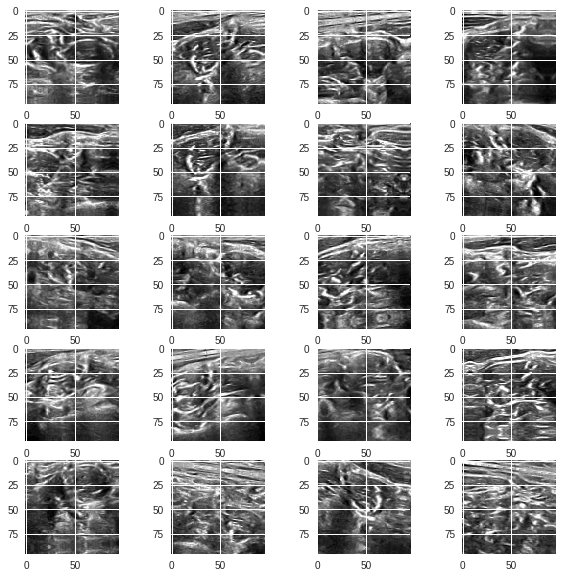

In [0]:
i = 0

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5

for mask in train_datagen.flow(image_train,batch_size=20):
    i += 1
    for i in range(1, columns*rows+1):
      img = np.reshape(mask,(20,96,96))[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img,cmap='gray')
    plt.show()
    if i > 1: 
        break

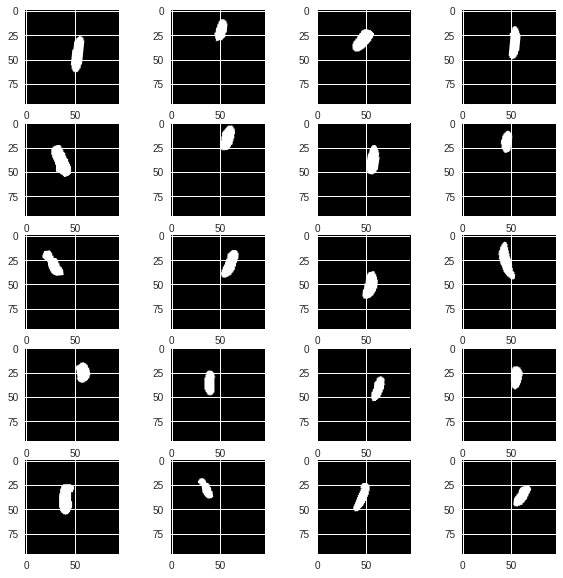

In [0]:
i = 0

w=10
h=10
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 5

for iamge in train_datagen.flow(mask_train,batch_size=20):
    i += 1
    for i in range(1, columns*rows+1):
      img = np.reshape(iamge,(20,96,96))[i-1]
      fig.add_subplot(rows, columns, i)
      plt.imshow(img,cmap='gray')
    plt.show()
    if i > 1: 
        break

In [0]:
print(('-'*30))
print('Fitting model...')
print(('-'*30))
from keras.callbacks import EarlyStopping, TensorBoard
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
tb_hist = TensorBoard(log_dir='./logs', 
                      histogram_freq=0, write_grads=True, write_images=True)

history = unet.fit_generator(train_data,steps_per_epoch=400, epochs=200, verbose=1, shuffle=True,
                   validation_data=valid_data, validation_steps=15 ,callbacks=[tb_hist,early_stopping,model_checkpoint])

print(('-'*30))
print('Done !!')
print(('-'*30))

------------------------------
Fitting model...
------------------------------
Epoch 1/200
400/400 [==============================] - 71s 178ms/step - loss: -0.0917 - dice_coef: 0.0917 - val_loss: -0.2606 - val_dice_coef: 0.2606
Epoch 2/200
400/400 [==============================] - 69s 172ms/step - loss: -0.4246 - dice_coef: 0.4246 - val_loss: -0.5022 - val_dice_coef: 0.5022
Epoch 3/200
400/400 [==============================] - 69s 172ms/step - loss: -0.4630 - dice_coef: 0.4630 - val_loss: -0.4769 - val_dice_coef: 0.4769
Epoch 4/200
400/400 [==============================] - 69s 172ms/step - loss: -0.4716 - dice_coef: 0.4716 - val_loss: -0.5073 - val_dice_coef: 0.5073
Epoch 5/200
400/400 [==============================] - 69s 172ms/step - loss: -0.4761 - dice_coef: 0.4761 - val_loss: -0.4925 - val_dice_coef: 0.4925
Epoch 6/200
400/400 [==============================] - 69s 172ms/step - loss: -0.4789 - dice_coef: 0.4789 - val_loss: -0.4839 - val_dice_coef: 0.4839
Epoch 7/200
400/400 [

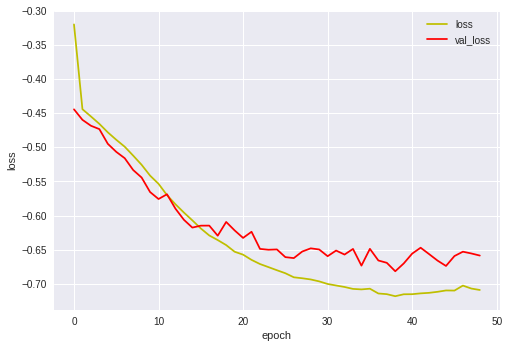

In [0]:
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

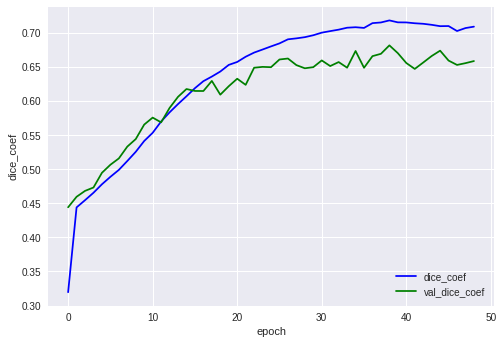

In [0]:
plt.plot(history.history['dice_coef'], 'b', label='dice_coef')
plt.plot(history.history['val_dice_coef'], 'g', label='val_dice_coef')
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.legend(loc='lower right')
plt.show()

In [0]:
import pandas as pd

df = pd.DataFrame({"loss": history.history['loss'],  "val_loss": history.history['val_loss'],
                   "dice_coef": history.history['dice_coef'],  "val_dice_coef": history.history['val_dice_coef'], })
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/history_{:2.2}.csv'.format(history.history['val_dice_coef'][-1]))
unet.save_weights("/content/gdrive/My Drive/Colab Notebooks/model_{:2.2}.h5".format(history.history['val_dice_coef'][-1]))

In [0]:
import cv2

mask_predict = unet.predict(image_valid, verbose=1)
score = unet.evaluate(mask_predict, mask_valid , verbose=1)

465/465 [==============================] - 1s 2ms/step


In [0]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: -0.3019920875308334
Test accuracy: 0.3019920875308334


In [0]:
mask_r = mask_predict.reshape(465, 96, 96)
mask_test_u = mask_valid.reshape(465, 96, 96)
image_test_u = image_valid.reshape(465, 96, 96)

In [0]:
img_test_o = (mask_r*2)+image_test_u
img_predict_o =image_test_u+(mask_test_u*2)

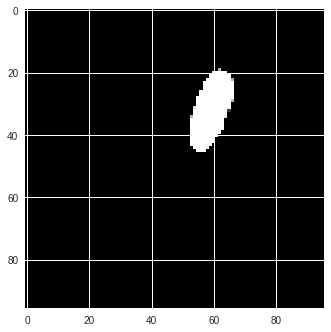

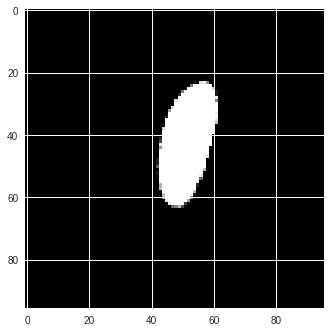

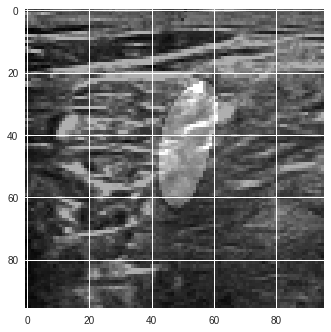

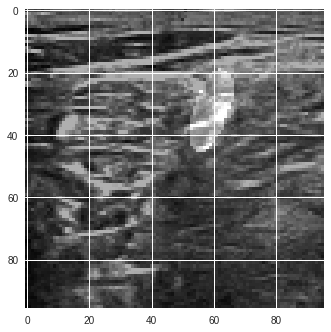

In [0]:
plt.figure()
plt.imshow(mask_test_u[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow( mask_r[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_test_o[35], cmap='gray')
plt.show()

plt.figure()
plt.imshow(img_predict_o[35], cmap='gray')
plt.show()

In [0]:
image_c.reshape(2323,9216)

array([[ 2.7227972 ,  2.7227972 ,  2.5639756 , ...,  0.3404758 ,
         0.7110591 ,  0.6934123 ],
       [ 2.1580987 ,  1.6286939 ,  1.8581027 , ..., -1.3359725 ,
        -1.388913  , -1.2300916 ],
       [ 1.5051662 ,  1.2404639 ,  0.9581146 , ..., -1.2653853 ,
        -1.2300916 , -1.2477384 ],
       ...,
       [ 2.7051504 ,  2.3698606 ,  2.5110352 , ...,  0.3404758 ,
        -0.17128211,  0.39341626],
       [ 2.7051504 ,  2.6875033 ,  2.7227972 , ..., -0.11834165,
        -0.22422259, -0.48892495],
       [ 2.7227972 ,  2.6522098 ,  2.6875033 , ..., -0.29480988,
        -0.48892495, -0.383044  ]], dtype=float32)

In [0]:
from sklearn.decomposition import PCA
pca3 = PCA(n_components=2)
W3 = pca3.fit_transform(image_c[0].reshape(32,9216))
X32 = pca3.inverse_transform(W3)
X33 =X32.reshape(32,96,96)

In [0]:
mean__ = pca3.mean_.reshape(96,96)
p1__ = pca3.components_[0].reshape(96,96)
p2__ = pca3.components_[1].reshape(96,96)

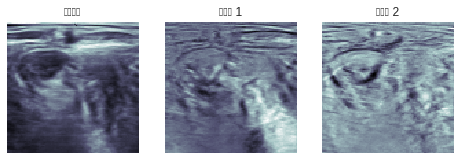

In [0]:
plt.subplot(131)
plt.imshow(mean__, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("평균얼굴")
plt.subplot(132)
plt.imshow(p1__, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("주성분 1")
plt.subplot(133)
plt.imshow(p2__, cmap=plt.cm.bone)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title("주성분 2")
plt.show()

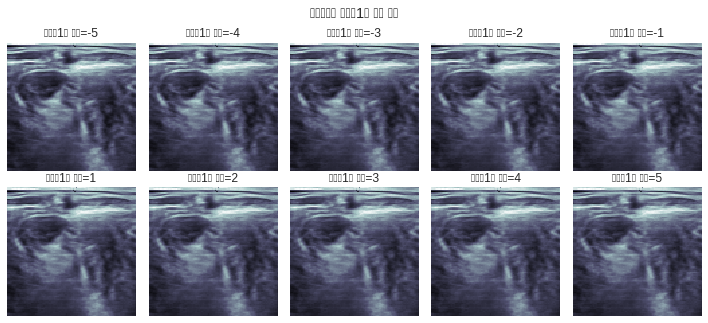

In [0]:
N = 2
M = 5
fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(top=1, bottom=0, hspace=0, wspace=0.05)
for i in range(N):
    for j in range(M):
        k = i * M + j
        ax = fig.add_subplot(N, M, k+1)
        w = k - 5 if k < 5 else k - 4
        ax.imshow(mean__ + w * p2__, cmap=plt.cm.bone)
        ax.grid(False)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.title("주성분1의 비중={}".format(w))
plt.suptitle("평균얼굴에 주성분1을 더한 사진")
plt.tight_layout()
plt.show()

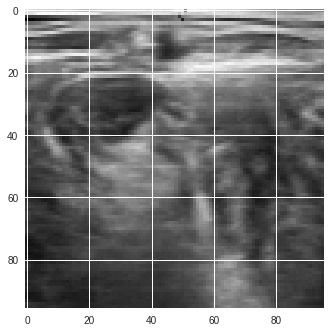

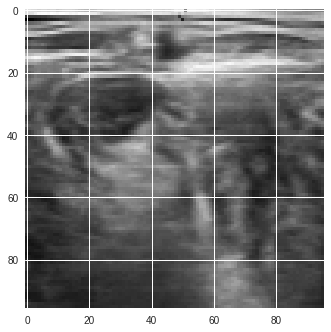

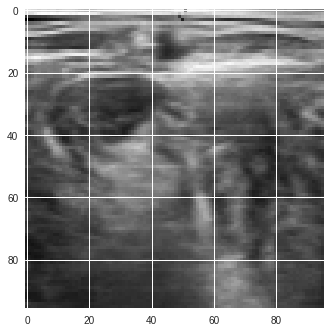

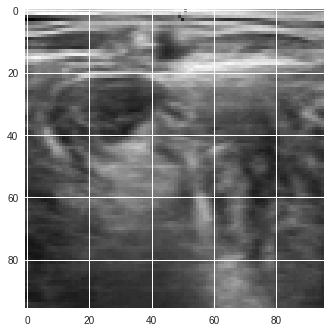

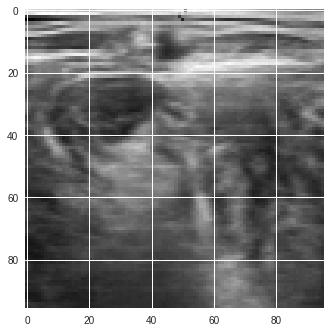

In [0]:
plt.imshow(mean__+(p1__*1) ,cmap='gray')
plt.show()
plt.imshow(mean__+(p1__*2) ,cmap='gray')
plt.show()
plt.imshow(mean__+(p1__*3) ,cmap='gray')
plt.show()
plt.imshow(mean__+(p1__*4) ,cmap='gray')
plt.show()
plt.imshow(mean__+(p1__*5) ,cmap='gray')
plt.show()